In [76]:
import pandas as pd
import sys
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [84]:

# Load the data
data = pd.read_csv('data.csv')

# Get the unique video IDs
video_ids = data['Video ID'].unique()

# Split the video IDs into training and testing sets
train_ids, test_ids = train_test_split(video_ids, test_size=0.5, random_state=42)

# Get the training and testing data
train_data = data[data['Video ID'].isin(train_ids)]
test_data = data[data['Video ID'].isin(test_ids)]


In [96]:

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out)
        return out

# Assume input_size=3 for crowd density, concealment, and loitering
model = LSTM(input_size=3, hidden_size=128, num_layers=2, output_size=1)

# Define a loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())




Epoch: 2/100 Progress: [=-------------------------------------------------]

Epoch: 100/100 Progress: [==================================================]

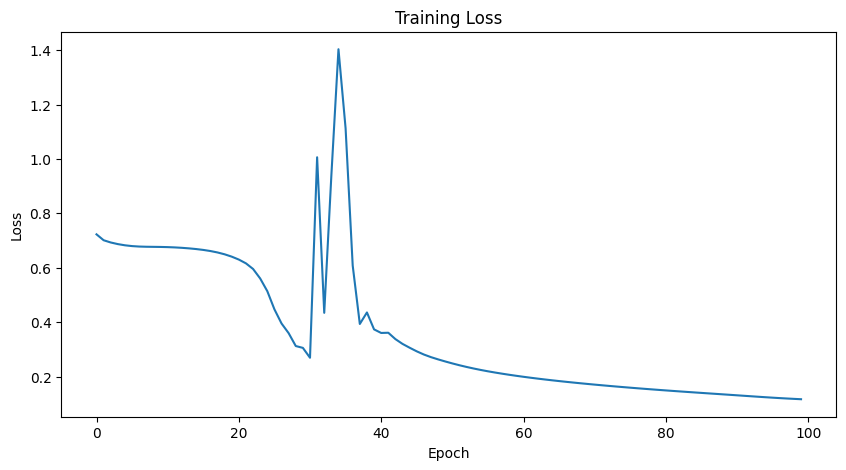

In [97]:

# Initialize a list to hold the losses for each epoch
train_losses = []

# Training loop
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0.0
    for video_id in train_ids:
        # Get the features and labels for the current video
        video_features = train_data[train_data['Video ID'] == video_id].iloc[:, 2:5]  # crowd density, concealment, and loitering
        video_labels = train_data[train_data['Video ID'] == video_id].iloc[:, 5]  # labels

        # Convert to PyTorch tensors and add an extra dimension for the batch size
        video_features = torch.unsqueeze(torch.tensor(video_features.values).float(), 0)
        video_labels = torch.unsqueeze(torch.tensor(video_labels.values).float(), 0)

        model.zero_grad()
        output = model(video_features).squeeze(-1)
        loss = criterion(output, video_labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average epoch loss
    epoch_loss = epoch_loss / len(train_ids)
    train_losses.append(epoch_loss)

    # Progress bar
    progress = (epoch + 1) / epochs
    filled_length = int(progress * 50)
    bar = '=' * filled_length + '-' * (50 - filled_length)
    sys.stdout.write(f'\rEpoch: {epoch + 1}/{epochs} Progress: [{bar}]')
    sys.stdout.flush()

# Plot the training loss
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [112]:

# Initialize lists to hold the true and predicted labels
true_labels = []
pred_labels = []

# Testing
for video_id in test_ids:
    # Get the features and labels for the current video
    video_features = test_data[test_data['Video ID'] == video_id].iloc[:, 2:5]  # crowd density, concealment, and loitering
    video_labels = test_data[test_data['Video ID'] == video_id].iloc[:, 5]  # labels

    # Convert to PyTorch tensors and add an extra dimension for the batch size
    video_features = torch.unsqueeze(torch.tensor(video_features.values).float(), 0)
    video_labels = torch.unsqueeze(torch.tensor(video_labels.values).float(), 0)

    with torch.no_grad():
        test_output = model(video_features).squeeze(-1)
        test_output = torch.sigmoid(test_output)  # Apply sigmoid to get the probabilities
        test_output = (test_output > 0.5).float()  # Apply a threshold to get the predicted labels
        

    true_labels.extend(video_labels.tolist())
    pred_labels.extend(test_output.tolist())
    # pred_labels.extend([round(pred, 2) for inlist in test_output.tolist() for pred in inlist])



In [113]:
true_labels

[[0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

In [114]:
pred_labels

[[0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0]]

In [ ]:

# Convert the one-hot encoded labels back to their original form
# true_labels_decoded = [label.index(1) for label in true_labels]
# pred_labels_decoded = [label.index(1) for label in pred_labels]
print("\n")
print("True labels: ", true_labels)
print("Predicted labels: ", pred_labels)
# print(true_labels_decoded)

# Plot the confusion matrix
# cm = confusion_matrix(true_labels_decoded, pred_labels_decoded)
# plt.figure(figsize=(10,10))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()
